# Converting CSD bands to audio

In [26]:
import src.paths

In [27]:
DATE = '2022-09-16'
CHANNEL_MIN = 0
CHANNEL_MAX = 59

In [28]:
%%time
path = src.paths.DATA / DATE / f'{DATE}-hpc-csd.pkl'
tau = 1 / 1250
csd = pd.read_pickle(path)
csd = csd.loc[0:7200 - tau, CHANNEL_MIN:CHANNEL_MAX]

CPU times: user 98.9 ms, sys: 2.75 s, total: 2.85 s
Wall time: 19.2 s


In [29]:
CHANNEL = 30
START = 0
END = 1800

In [30]:
raw = csd.loc[START:END - tau, CHANNEL]

In [31]:
THETA_MIN = 2
THETA_MAX = 15
LGAMMA_MIN = 30
LGAMMA_MAX = 60
HGAMMA_MIN = 60
HGAMMA_MAX = 100

In [32]:
sos = scipy.signal.butter(5, Wn=[THETA_MIN, THETA_MAX], fs=1250, btype='band', output='sos')
theta = scipy.signal.sosfiltfilt(sos, raw, axis=0)
sos = scipy.signal.butter(5, Wn=[LGAMMA_MIN, LGAMMA_MAX], fs=1250, btype='band', output='sos')
lgamma = scipy.signal.sosfiltfilt(sos, raw, axis=0)
sos = scipy.signal.butter(5, Wn=[HGAMMA_MIN, HGAMMA_MAX], fs=1250, btype='band', output='sos')
hgamma = scipy.signal.sosfiltfilt(sos, raw, axis=0)

In [33]:
GAIN = 0.1

In [34]:
%%time
t1 = pd.date_range(start=0, periods=len(raw), freq='0.8ms')
t2 = np.linspace(0, END - START, 44100 * (END - START) + 1)[:-1]
t2 = (t2 * 1e15).astype('int').astype('datetime64[fs]')
df = pd.DataFrame({
    'theta': theta,
    'lgamma': lgamma,
    'hgamma': hgamma,
}).set_index(t1).reindex(t2).interpolate(method='cubic')
df.index = pd.Series(np.linspace(START, END, len(df) + 1)[:-1], name='time')

CPU times: user 44.3 s, sys: 9.35 s, total: 53.7 s
Wall time: 53.5 s


In [37]:
df = df.dropna()

In [38]:
int24 = (2 ** 23 - 1)
df -= df.mean(axis=0)
df /= df.std(axis=0)
df = np.clip(GAIN * df * int24, -int24, int24).astype('int32')

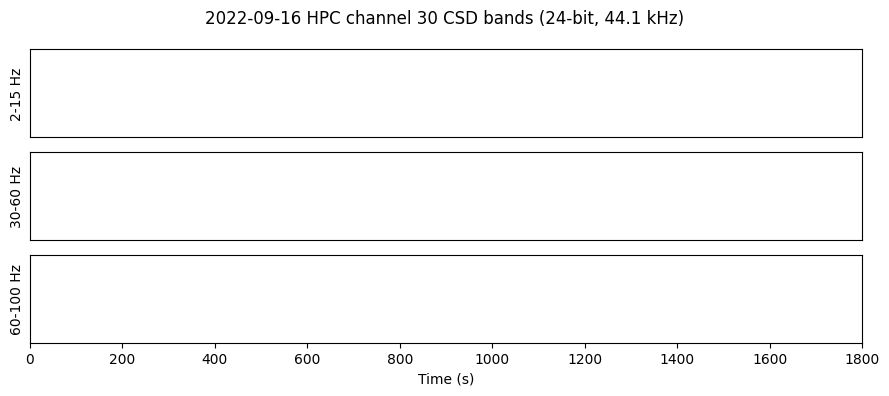

In [39]:
fig, axs = plt.subplots(3, 1, figsize=(9, 4))
plt.suptitle(f'{DATE} HPC channel {CHANNEL} CSD bands (24-bit, 44.1 kHz)')

for i, (band, x) in enumerate(df.items()):
    plt.sca(axs[i])

    # plt.plot(x)
    plt.ylim([-int24, int24])
    plt.yticks([]) 
    plt.xlim([START, END])
    ylabel = {
        'theta': f'{THETA_MIN}-{THETA_MAX} Hz',
        'lgamma': f'{LGAMMA_MIN}-{LGAMMA_MAX} Hz',
        'hgamma': f'{HGAMMA_MIN}-{HGAMMA_MAX} Hz',
    }[band]
    plt.ylabel(ylabel)
    if i == len(df.columns) - 1:
        plt.xlabel('Time (s)')
    else:
        plt.xticks([])

plt.tight_layout()
plt.savefig(f'{DATE}-hpc-channel-{CHANNEL}-time-{START}-{END}-csd-audio-cubic.png', dpi=300)
plt.show()

In [40]:
import soundfile

In [42]:
for band in ['theta', 'lgamma', 'hgamma']:
    stereo = np.stack([df[band], df[band]]).T
    path = f'{DATE}-hpc-channel-{CHANNEL}-time-{START}-{END}-csd-{band}-cubic.wav'
    soundfile.write(path, stereo, 44100, subtype='PCM_24')